Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0843 - val_loss: 0.0974
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0889 - val_loss: 0.0956
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0813 - val_loss: 0.0939
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0787 - val_loss: 0.0922
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0771 - val_loss: 0.0906
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0771 - val_loss: 0.0890
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0750 - val_loss: 0.0875
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0770 - val_loss: 0.0861
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0730 - val_loss: 0.0848
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0711 - val_loss: 0.0835
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0698 - val_loss: 0.0823
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0672 - val_lo

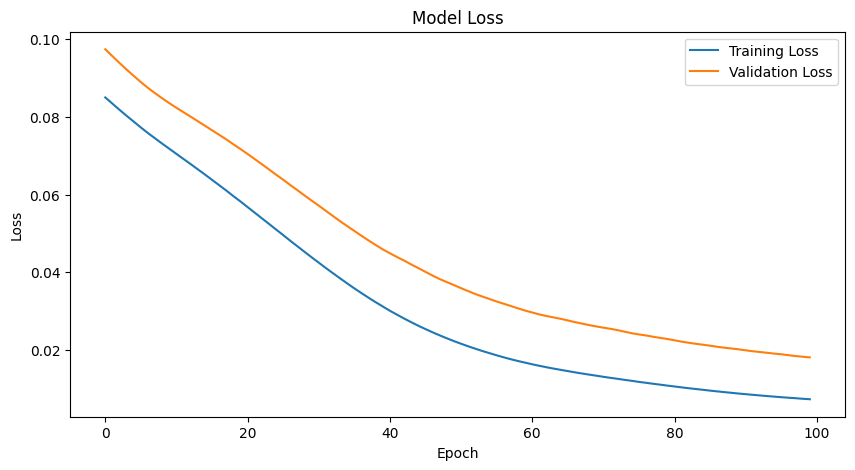

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


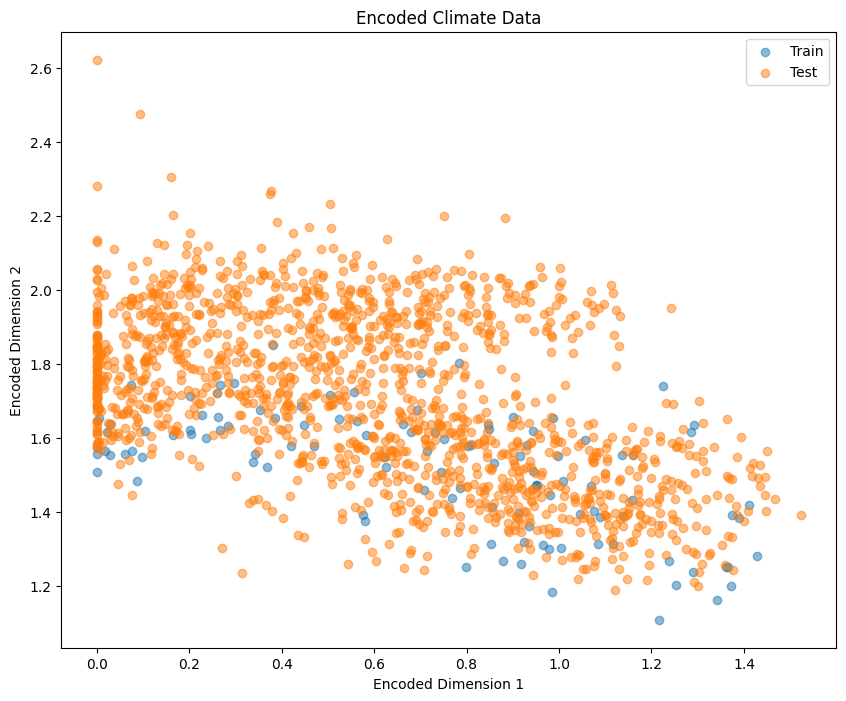

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Average Train MSE: 0.0073
Average Test MSE: 0.0181


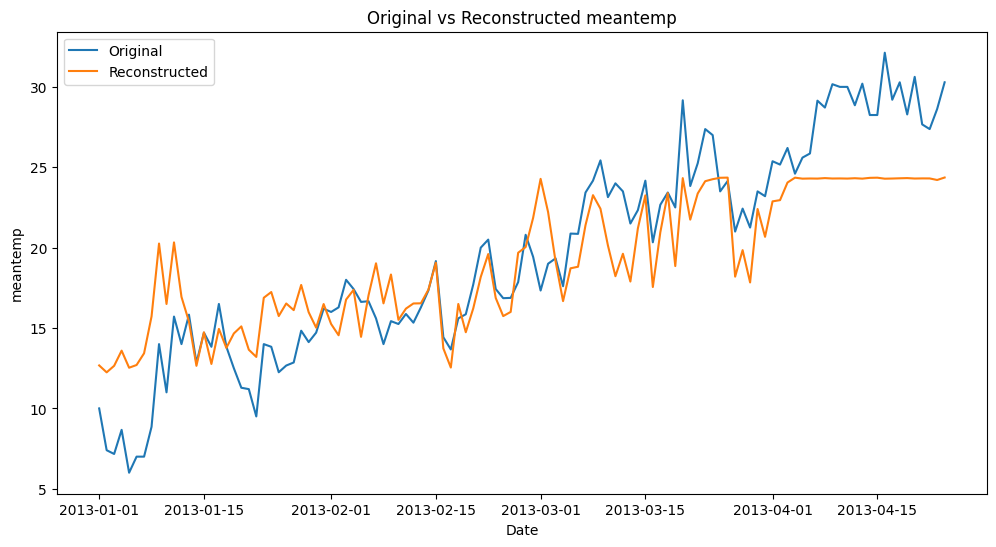

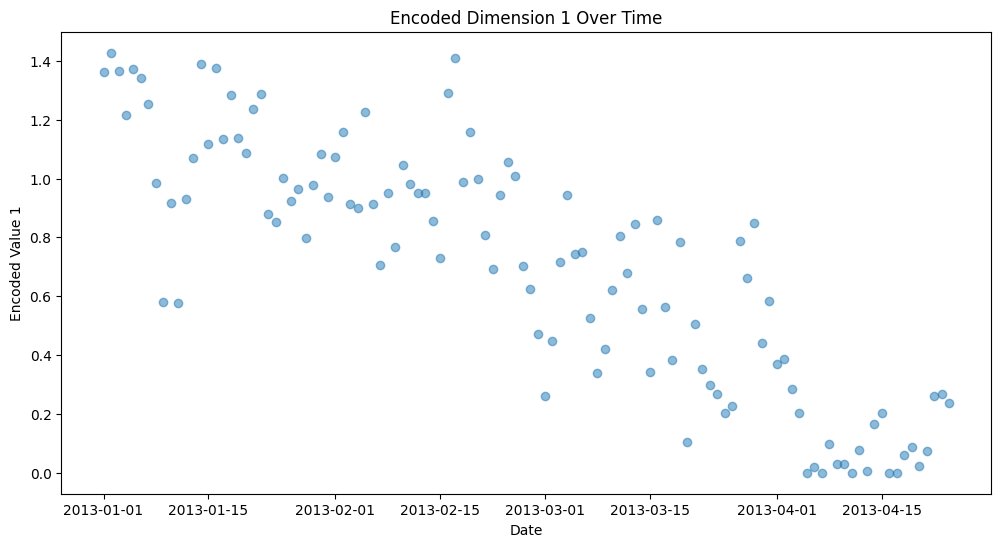

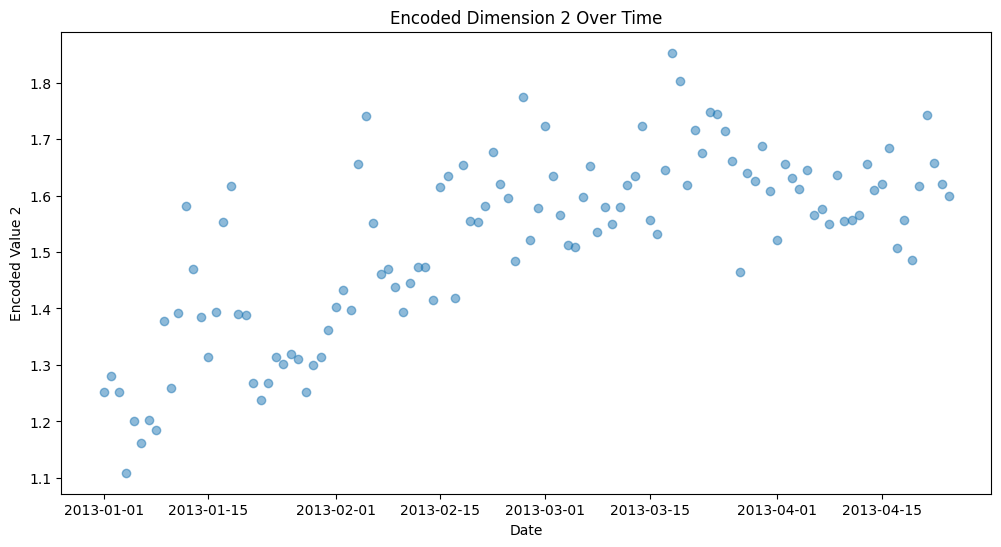

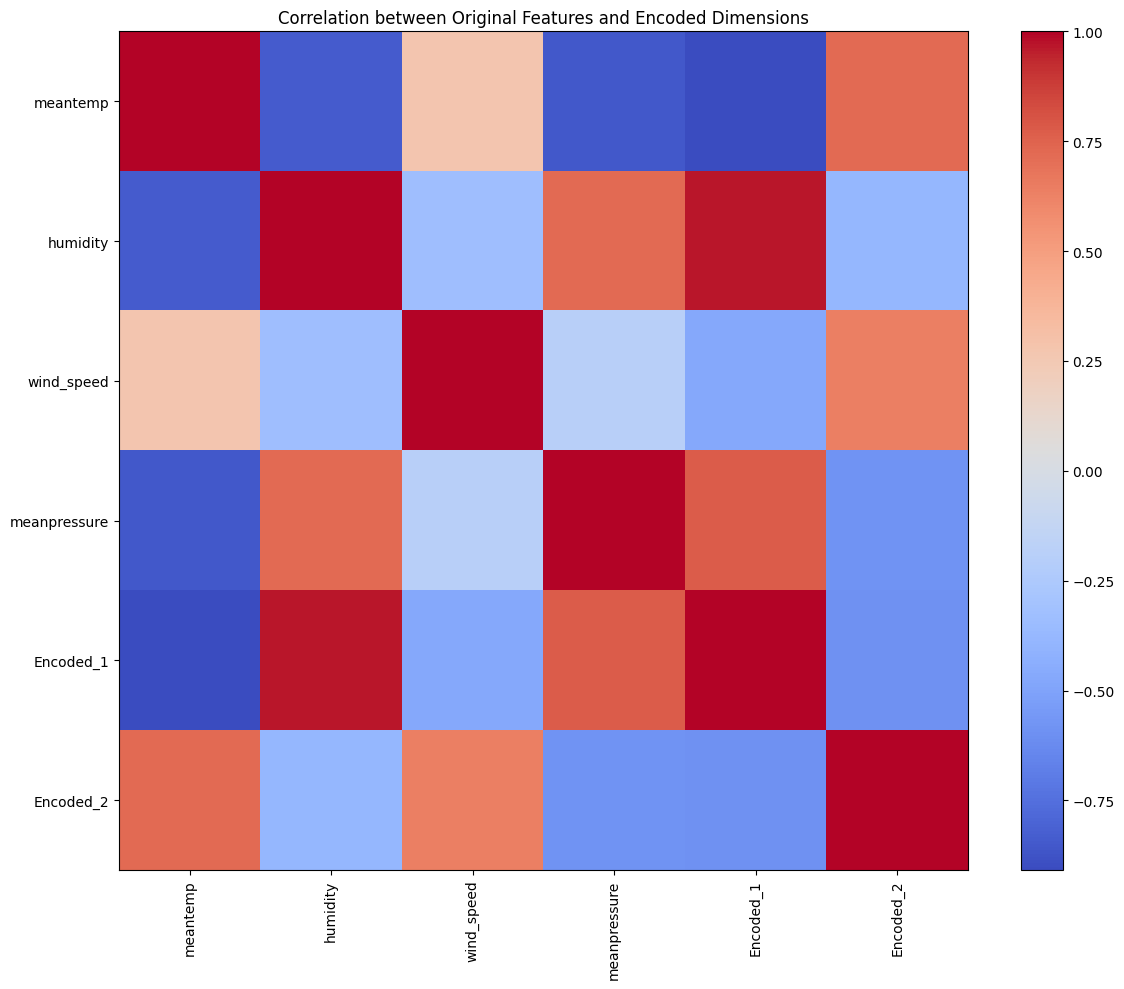

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Load the data
train_data = pd.read_csv('DailyDelhiClimateTest.csv')
test_data = pd.read_csv('DailyDelhiClimateTrain.csv')

# Combine train and test data for preprocessing
all_data = pd.concat([train_data, test_data], axis=0)

# Convert date to datetime
all_data['date'] = pd.to_datetime(all_data['date'])

# Sort data by date
all_data = all_data.sort_values('date')

# Select features for the model
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(all_data[features])

# Split back into train and test
train_data = scaled_data[:len(train_data)]
test_data = scaled_data[len(train_data):]

# Define the autoencoder architecture
input_dim = len(features)
encoding_dim = 2  # Reduce to 2 dimensions

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
history = autoencoder.fit(train_data, train_data,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(test_data, test_data))

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Encode the data
encoded_train = encoder.predict(train_data)
encoded_test = encoder.predict(test_data)

# Visualize the encoded data
plt.figure(figsize=(10, 8))
plt.scatter(encoded_train[:, 0], encoded_train[:, 1], alpha=0.5, label='Train')
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], alpha=0.5, label='Test')
plt.title('Encoded Climate Data')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.show()

# Reconstruct the data
reconstructed_train = autoencoder.predict(train_data)
reconstructed_test = autoencoder.predict(test_data)

# Calculate reconstruction error
train_mse = np.mean(np.power(train_data - reconstructed_train, 2), axis=1)
test_mse = np.mean(np.power(test_data - reconstructed_test, 2), axis=1)

print(f"Average Train MSE: {np.mean(train_mse):.4f}")
print(f"Average Test MSE: {np.mean(test_mse):.4f}")

# Visualize original vs reconstructed data for a sample feature
feature_index = 0  # Index of the feature to visualize (e.g., meantemp)
original = scaler.inverse_transform(train_data)[:, feature_index]
reconstructed = scaler.inverse_transform(reconstructed_train)[:, feature_index]

plt.figure(figsize=(12, 6))
plt.plot(all_data['date'][:len(train_data)], original, label='Original')
plt.plot(all_data['date'][:len(train_data)], reconstructed, label='Reconstructed')
plt.title(f'Original vs Reconstructed {features[feature_index]}')
plt.xlabel('Date')
plt.ylabel(features[feature_index])
plt.legend()
plt.show()

# Analyze the encoded dimensions
for i in range(encoding_dim):
    plt.figure(figsize=(12, 6))
    plt.scatter(all_data['date'][:len(train_data)], encoded_train[:, i], alpha=0.5)
    plt.title(f'Encoded Dimension {i+1} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'Encoded Value {i+1}')
    plt.show()

# Correlation analysis
encoded_df = pd.DataFrame(encoded_train, columns=[f'Encoded_{i+1}' for i in range(encoding_dim)])
encoded_df['date'] = all_data['date'][:len(train_data)]
encoded_df = encoded_df.set_index('date')

original_df = all_data[features].iloc[:len(train_data)].set_index(all_data['date'][:len(train_data)])

correlation = pd.concat([original_df, encoded_df], axis=1).corr()

plt.figure(figsize=(12, 10))
plt.imshow(correlation, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.title('Correlation between Original Features and Encoded Dimensions')
plt.tight_layout()
plt.show()


--- Anomaly Detection ---

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Anomaly threshold: 0.0429
Total anomalies detected: 79
Percentage of anomalies: 5.01%


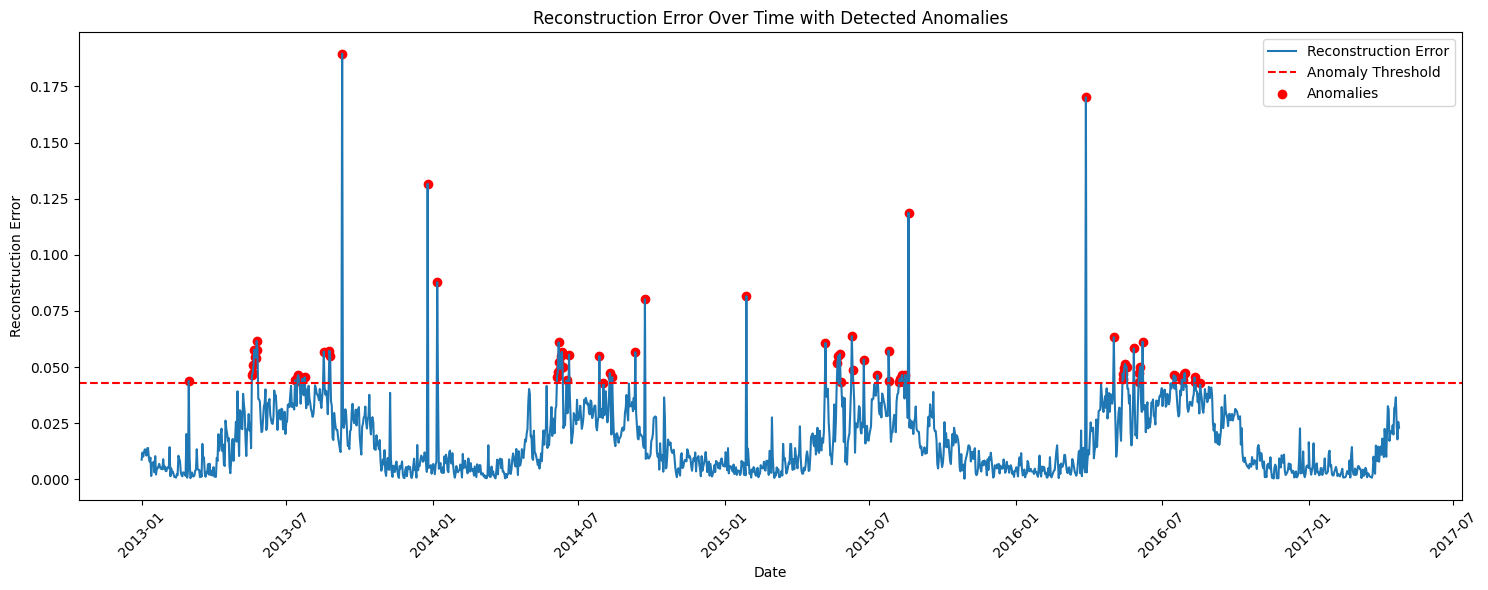

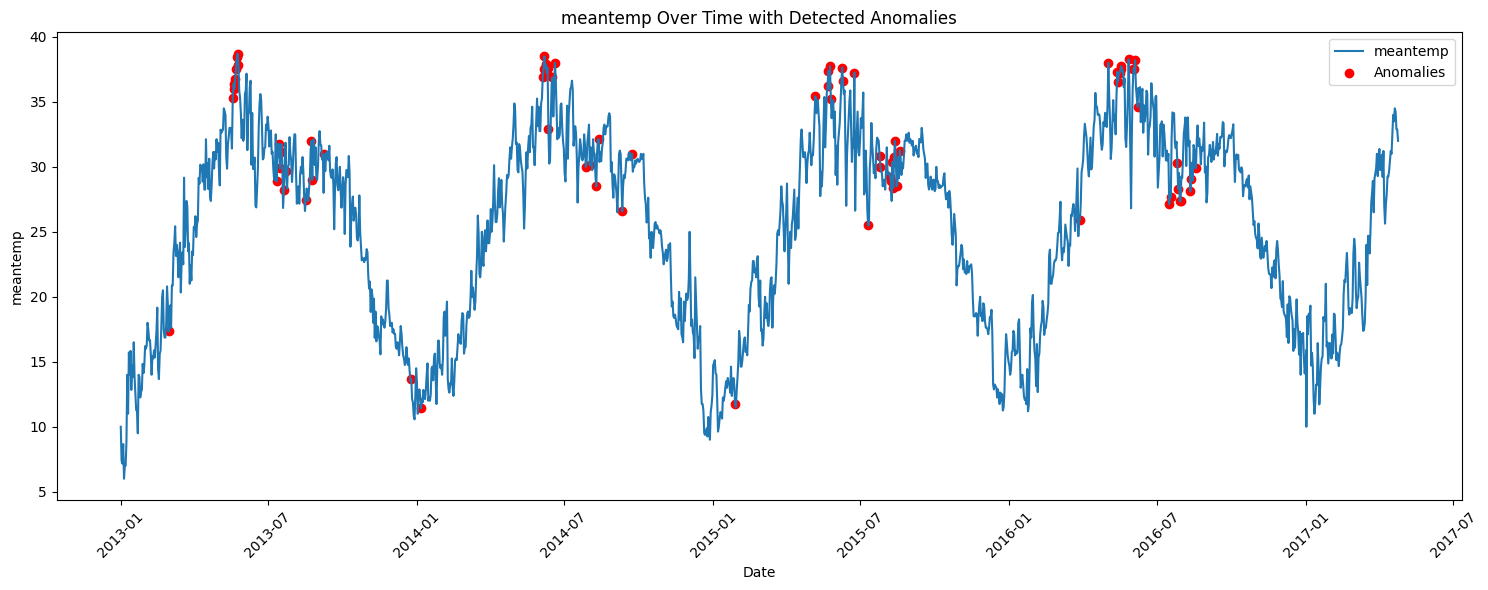

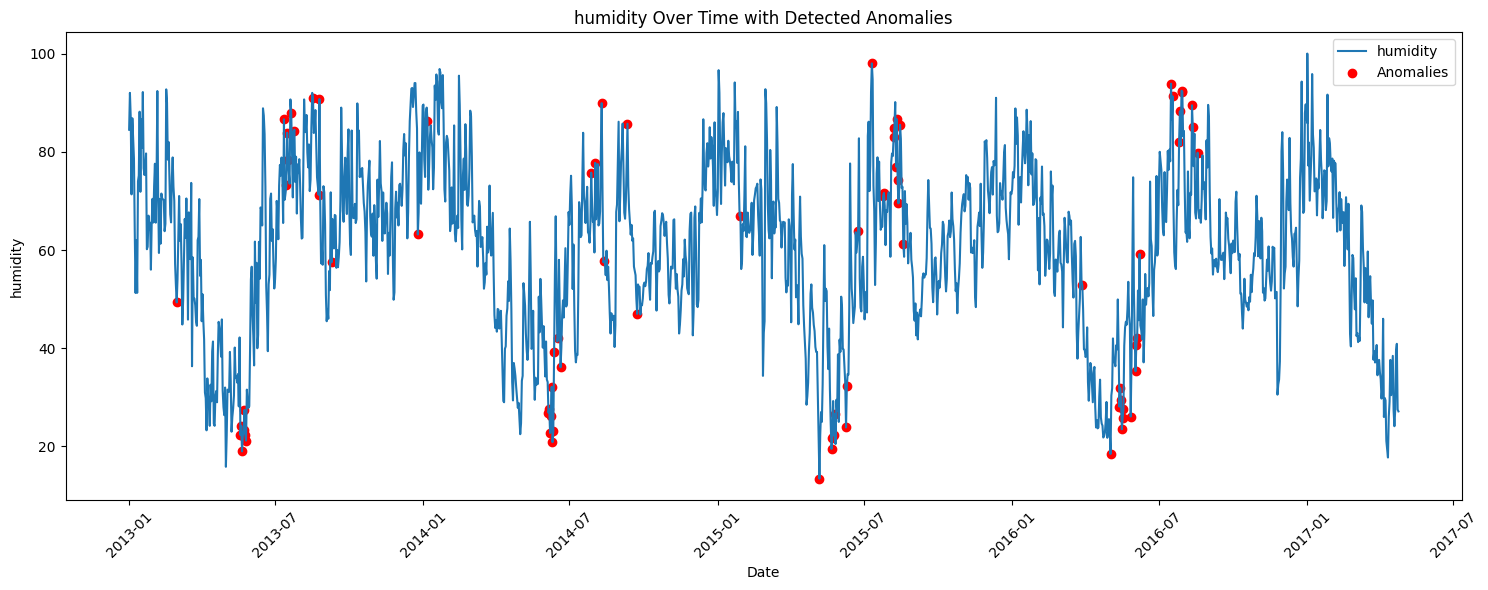

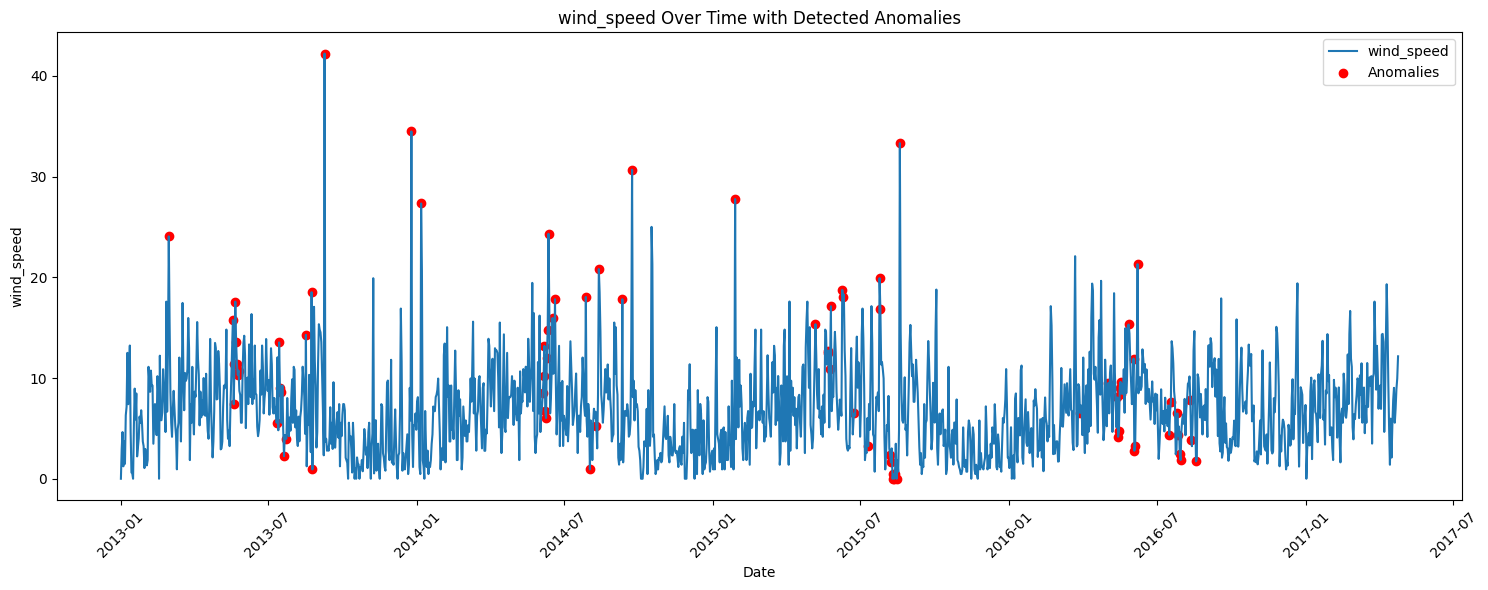

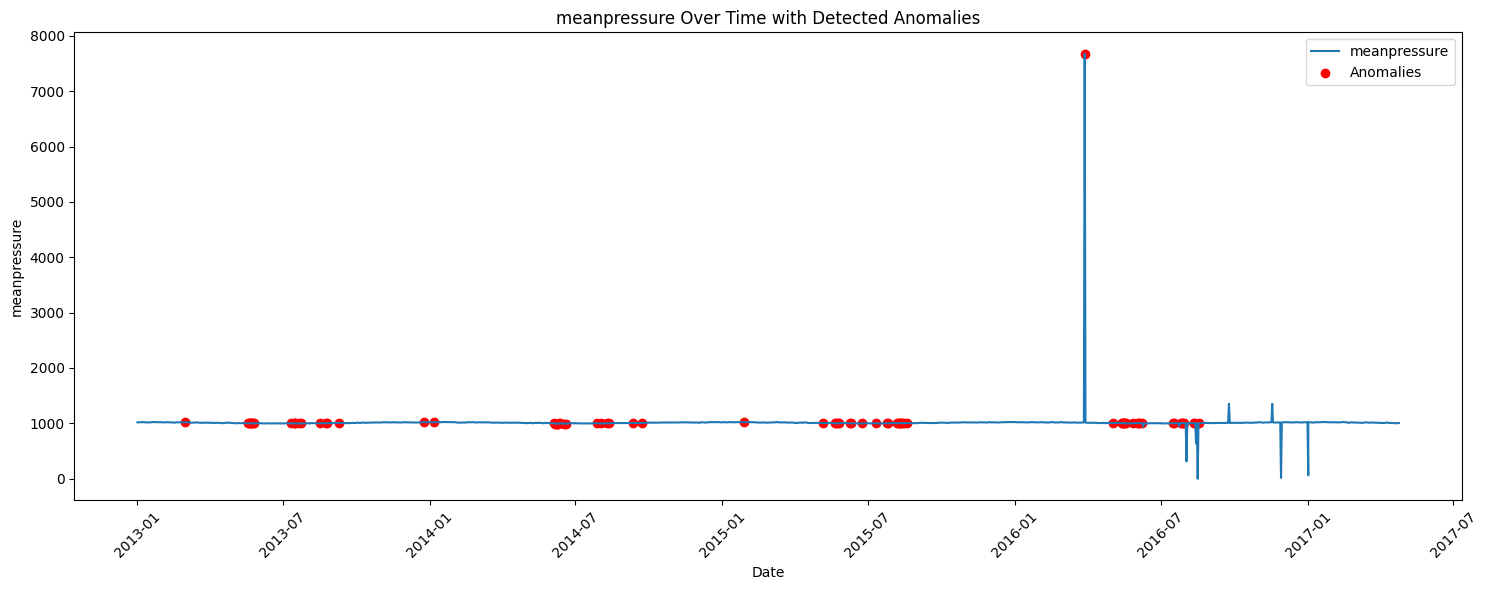


Top 10 Anomalies:
           date   meantemp   humidity  wind_speed  meanpressure  \
251  2013-09-09  31.000000  57.500000   42.220000   1007.000000   
1182 2016-03-28  25.933333  52.800000    6.546667   7679.333333   
358  2013-12-25  13.666667  63.166667   34.487500   1020.625000   
960  2015-08-19  31.250000  61.250000   33.325000   1002.375000   
370  2014-01-06  11.428571  86.285714   27.337500   1017.625000   
757  2015-01-28  11.714286  67.000000   27.775000   1018.250000   
630  2014-09-23  31.000000  47.000000   30.685714   1004.285714   
889  2015-06-09  37.625000  23.875000   18.750000    998.875000   
1217 2016-05-02  38.000000  18.466667    9.513333   1002.200000   
144  2013-05-25  38.714286  22.428571   10.314286    998.142857   

      reconstruction_error  
251               0.189609  
1182              0.170127  
358               0.131599  
960               0.118748  
370               0.087770  
757               0.081555  
630               0.080188  
889        

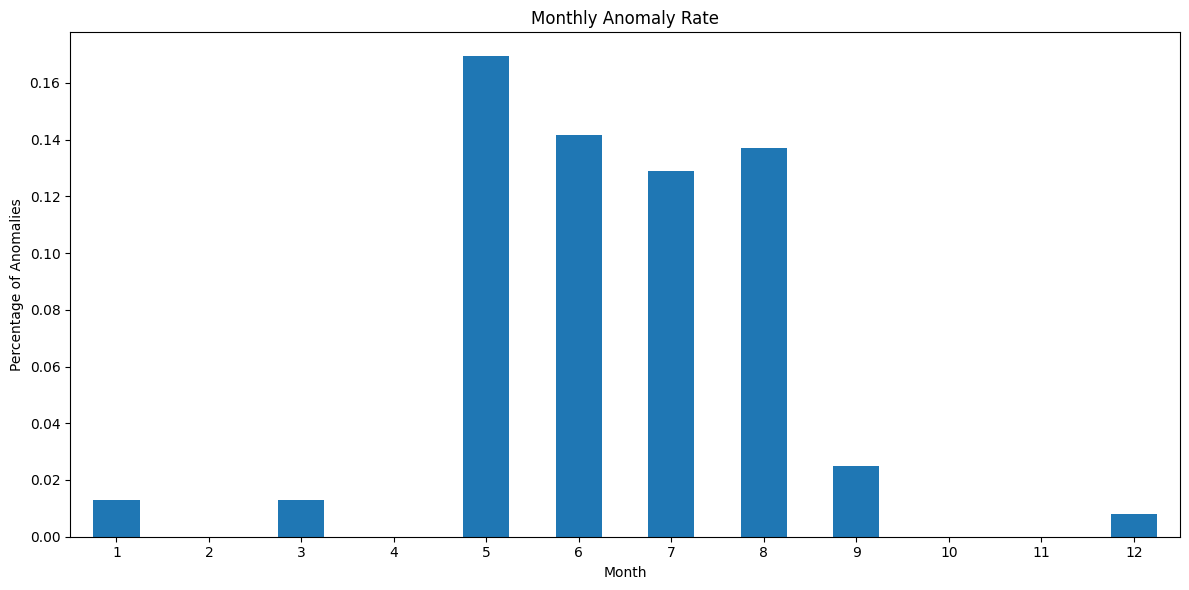


Correlation between features and anomaly likelihood:
is_anomaly      1.000000
wind_speed      0.228361
meantemp        0.219791
meanpressure    0.097570
humidity       -0.080511
Name: is_anomaly, dtype: float64


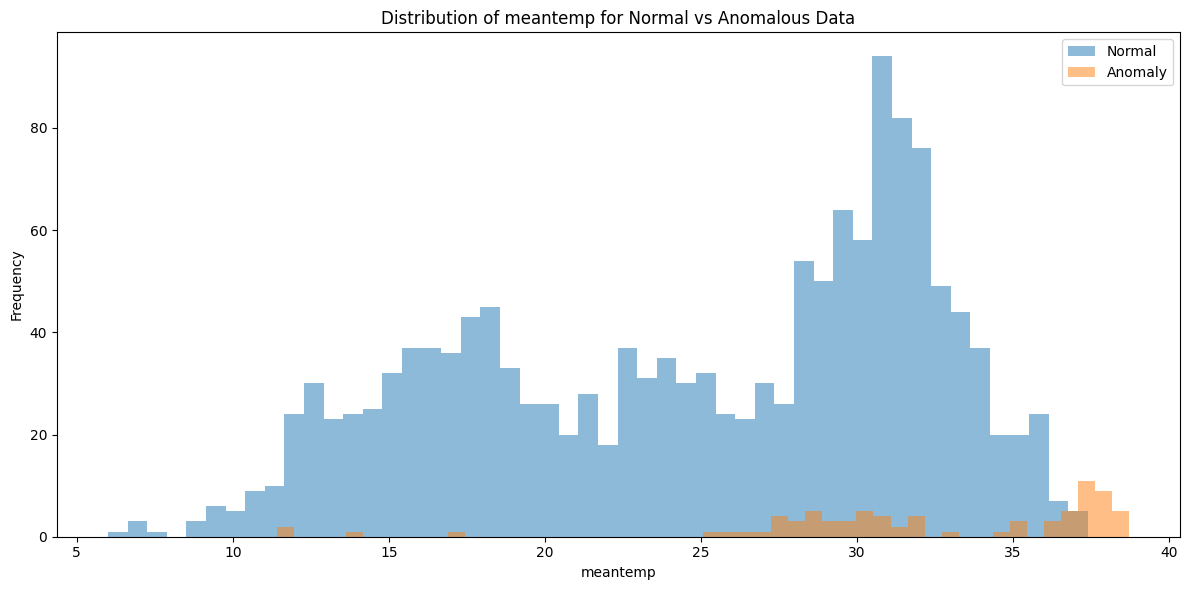

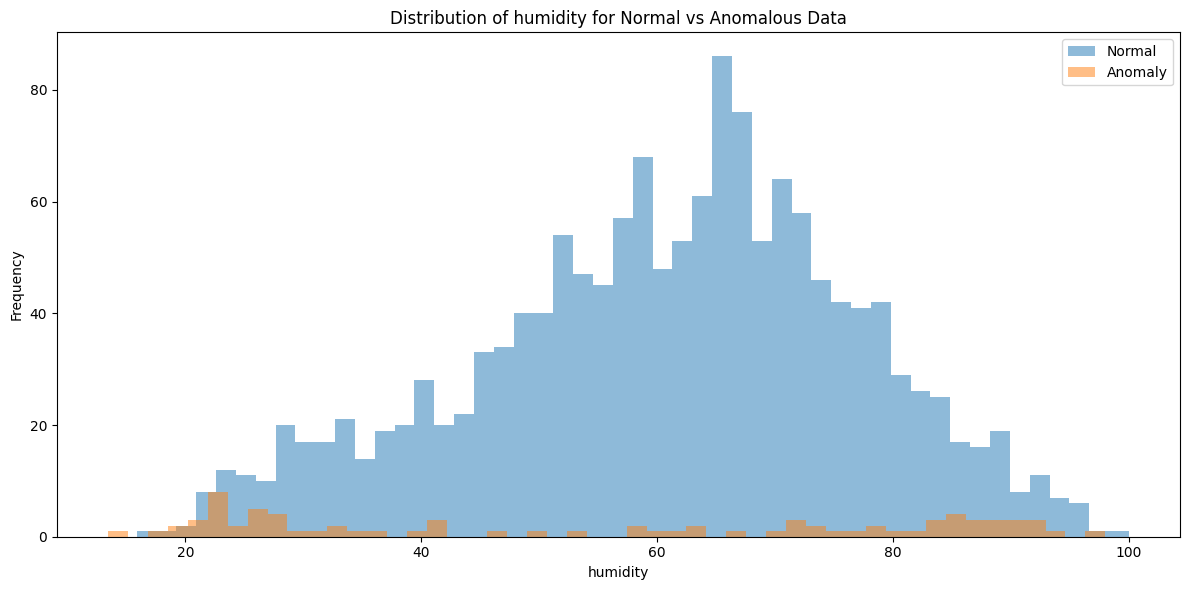

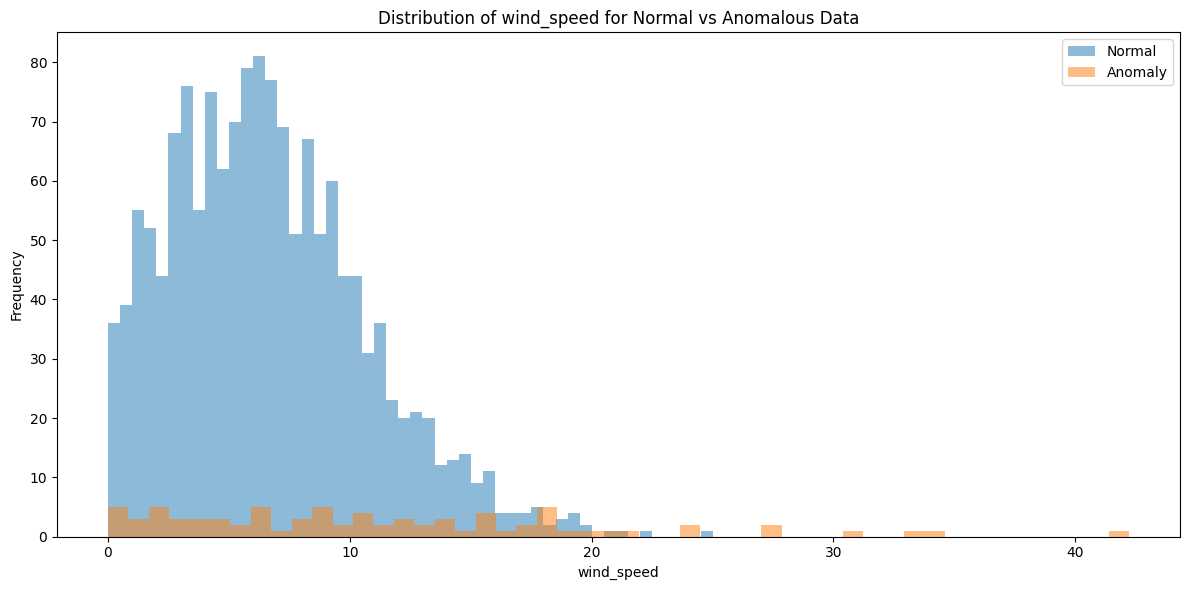

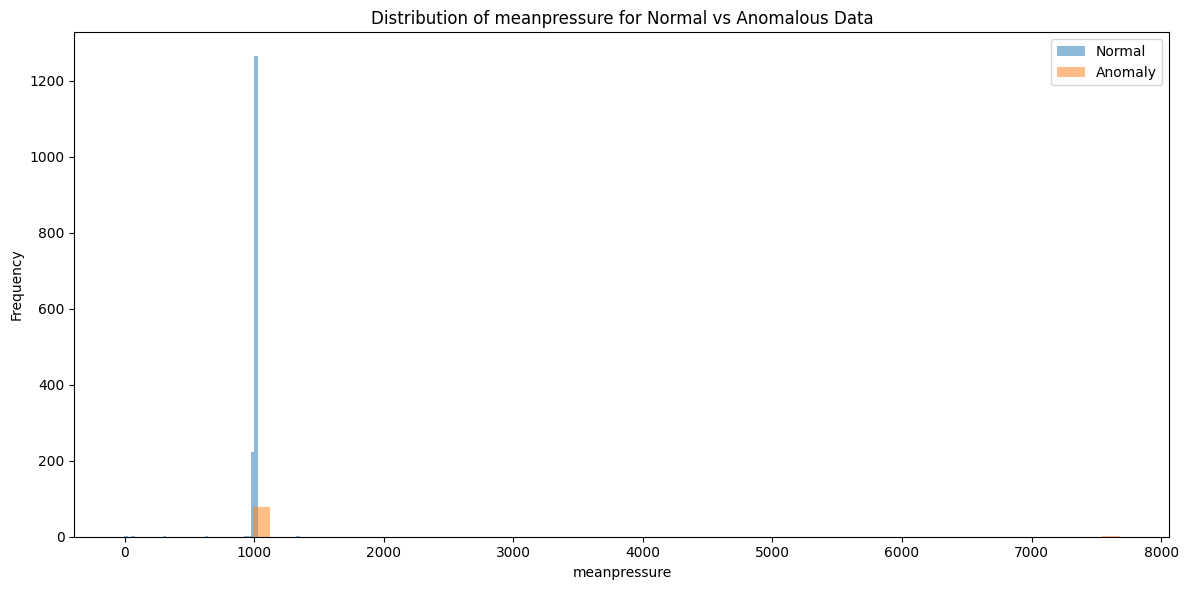

In [2]:
# Anomaly Detection Section

print("\n--- Anomaly Detection ---\n")

# Calculate reconstruction error for each data point
reconstruction_error = np.mean(np.power(scaled_data - autoencoder.predict(scaled_data), 2), axis=1)

# Determine threshold for anomalies (e.g., 95th percentile of reconstruction error)
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly threshold: {threshold:.4f}")

# Identify anomalies
anomalies = reconstruction_error > threshold

# Add reconstruction error and anomaly flag to the original dataframe
all_data['reconstruction_error'] = reconstruction_error
all_data['is_anomaly'] = anomalies

# Print summary of detected anomalies
print(f"Total anomalies detected: {np.sum(anomalies)}")
print(f"Percentage of anomalies: {np.mean(anomalies)*100:.2f}%")

# Visualize reconstruction error over time
plt.figure(figsize=(15, 6))
plt.plot(all_data['date'], all_data['reconstruction_error'], label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.scatter(all_data['date'][anomalies], all_data['reconstruction_error'][anomalies],
            color='red', label='Anomalies')
plt.title('Reconstruction Error Over Time with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze anomalies for each feature
for feature in features:
    plt.figure(figsize=(15, 6))
    plt.plot(all_data['date'], all_data[feature], label=feature)
    plt.scatter(all_data['date'][anomalies], all_data[feature][anomalies],
                color='red', label='Anomalies')
    plt.title(f'{feature} Over Time with Detected Anomalies')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Print top 10 anomalies
print("\nTop 10 Anomalies:")
top_anomalies = all_data[anomalies].sort_values('reconstruction_error', ascending=False).head(10)
print(top_anomalies[['date'] + features + ['reconstruction_error']])

# Analyze seasonal patterns in anomalies
all_data['month'] = all_data['date'].dt.month
monthly_anomaly_rate = all_data.groupby('month')['is_anomaly'].mean()

plt.figure(figsize=(12, 6))
monthly_anomaly_rate.plot(kind='bar')
plt.title('Monthly Anomaly Rate')
plt.xlabel('Month')
plt.ylabel('Percentage of Anomalies')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Correlation between features and anomaly likelihood
correlation_with_anomaly = all_data[features + ['is_anomaly']].corr()['is_anomaly'].sort_values(ascending=False)
print("\nCorrelation between features and anomaly likelihood:")
print(correlation_with_anomaly)

# Visualize feature distributions for normal vs anomalous data
for feature in features:
    plt.figure(figsize=(12, 6))
    plt.hist(all_data[all_data['is_anomaly'] == False][feature], bins=50, alpha=0.5, label='Normal')
    plt.hist(all_data[all_data['is_anomaly'] == True][feature], bins=50, alpha=0.5, label='Anomaly')
    plt.title(f'Distribution of {feature} for Normal vs Anomalous Data')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()